# Basic Model: Five-Layer Model

Because of the simplicity of the network, we decided to replicate their exercise of reproducing the results of [Kim et al](https://openaccess.thecvf.com/content_cvpr_2016_workshops/w28/papers/Kim_Fusing_Aligned_and_CVPR_2016_paper.pdf).

    B.-K. Kim, S.-Y. Dong, J. Roh, G. Kim, and S.-Y. Lee, “Fusing Aligned and Non-Aligned Face Information for Automatic Affect Recognition in the Wild: A Deep Learning Approach,” in IEEE Conf. Computer Vision and Pattern Recognition (CVPR) Workshops, 2016, pp. 48–57.

This model consists of three stages of convolutional and max-pooling layers, followed by an FC layer of size 1024 and a softmax output layer. 

The convolutional layers use 32, 32, and 64 filters of size 5x5, 4x4, and 5x5, respectively. The max-pooling layers use kernels of size 3x3 and stride 2. ReLU was utilized as the activation function. To improve performance, we also added batchnorm at every layer and 30% dropout after the last FC layer. 

<p><b> The architecture of neural network </b></p>
<img src="Architecture_NN.jpg" alt=" The architecture of neural network" width="800">

Also, we use **Test-Time Augmentation(TTA)** with horizontal flip and seven augmented images to improve the test accuracy of our five-layer

## Import Dependencies 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.python.lib.io import file_io

import keras
from keras.preprocessing.image import ImageDataGenerator

from keras.models import load_model, Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD # Stochastic gradient descent
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.metrics import confusion_matrix
from seaborn import heatmap # seaborn: statistical data visualization¶

%matplotlib inline

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
print('Importing successfully!')
print('tensorflow',tf.__version__)
print('keras',keras.__version__)
print('GPU',tf.config.list_physical_devices('GPU'))

Importing successfully!
tensorflow 2.3.0
keras 2.4.3
GPU [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Import datasets

In [3]:
BS = 128 # batch size,batch size = 128

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(48, 48),
            color_mode='grayscale',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [5]:
train_generator  = get_datagen("/usr/users/gpupro/gprcsr1_1/Desktop/ST7_FER_Projet/FER_Dataset/train", True)
dev_generator    = get_datagen("/usr/users/gpupro/gprcsr1_1/Desktop/ST7_FER_Projet/FER_Dataset/test-private")
test_generator  = get_datagen("/usr/users/gpupro/gprcsr1_1/Desktop/ST7_FER_Projet/FER_Dataset/test-public")

Found 29903 images belonging to 7 classes.
Found 3590 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


## Build the basic model

<p><b> The architecture of neural network </b></p>
<img src="Architecture_NN.jpg" alt=" The architecture of neural network" width="800">

To fine tune the model, we trained it for 300 epochs, optimizing the cross-entropy loss using stochastic gradient descent with a momentum of 0.9. The initial learning rate, batch size, and weight decay are fixed at 0.01, 128, and 0.0001, respectively. 

The learning rate is halved if the validation accuracy does not improve for 10 epochs.

In [6]:
Dropout_rate = 0.3
SGD_lr = 0.1 # learning rate of SGD optimiser
SGD_decay = 0.001 #decay of SGD

In [7]:
model = keras.Sequential()

model.add(BatchNormalization(input_shape=(48,48,1)))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same', input_shape=(48,48,1),name="conv1"))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool1"))
model.add(Dropout(0.2))

model.add(Conv2D(32, (3, 3), activation='relu',padding='same',name="conv2"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool2"))         
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv3"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool3"))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu',padding='same',name="conv4"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2),name="maxpool4"))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation='relu',name='fc1'))
model.add(Dropout(Dropout_rate))
model.add(BatchNormalization())

model.add(Dense(7, activation='softmax',name='fcsoftmax'))

# model = keras.Sequential()

# model.add(BatchNormalization(input_shape=(48,48,1)))

# model.add(Conv2D(32, (5, 5), activation='relu',padding='same',name="conv1"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3, 3),name="maxpool2"))         
# # model.add(Dropout(0.2))

# model.add(Conv2D(32, (4, 4), activation='relu',padding='same',name="conv2"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3, 3),name="maxpool3"))
# # model.add(Dropout(0.2))

# model.add(Conv2D(64, (5, 5), activation='relu',padding='same',name="conv3"))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=(3, 3),name="maxpool4"))
# # model.add(Dropout(0.2))

# model.add(Flatten())
# model.add(Dense(1024, activation='relu',name='fc1'))
# model.add(Dropout(Dropout_rate))
# model.add(BatchNormalization())

# model.add(Dense(7, activation='softmax',name='fc2_softmax'))

 
sgd = tf.keras.optimizers.SGD(lr=SGD_lr, momentum=0.9, decay=SGD_decay, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

## Train the model

More information about **keras.model**, please refer to the [official tutorial](https://www.tensorflow.org/api_docs/python/tf/keras/Model)

In [8]:
Epochs = 300

In [9]:
#  The learning rate is halved if the validation accuracy does not improve for 10 epochs.
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',factor=0.5, patience=10, min_lr=0.00001,mode='max')
# define the checkpoint
cp_filepath='Basic-weights-best.hdf5'
checkpoint = ModelCheckpoint(cp_filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

hist = model.fit_generator(
    generator = train_generator,
    validation_data=dev_generator, 
    #steps_per_epoch=28709// BS,
    #validation_steps=3509 // BS,
    shuffle=True,
    epochs=Epochs,
    callbacks=[rlrop,checkpoint],
    use_multiprocessing=False,
) 

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/300
234/234 [==============================] - ETA: 0s - loss: 2.7784 - accuracy: 0.2240
Epoch 00001: val_accuracy improved from -inf to 0.21198, saving model to Basic-weights-best.hdf5
234/234 [==============================] - 48s 207ms/step - loss: 2.7784 - accuracy: 0.2240 - val_loss: 1.9000 - val_accuracy: 0.2120
Epoch 2/300
234/234 [==============================] - ETA: 0s - loss: 1.8903 - accuracy: 0.2863
Epoch 00002: val_accuracy improved from 0.21198 to 0.33621, saving model to Basic-weights-best.hdf5
234/234 [==============================] - 40s 169ms/step - loss: 1.8903 - accuracy: 0.2863 - val_loss: 1.7065 - val_accuracy: 0.3362
Epoch 3/300
234/234 [==============================] - ETA: 0s - loss: 1.7183 - accuracy: 0.3268
Epoch 00003: val_accuracy did not improve from 0.33621
234/234 [==============================] - 39s 165ms/step - loss: 1.7183 - accuracy: 0.3268 - val_loss: 161.5068 

In [10]:
print('the keys of the trained model:','\n', hist.history.keys())

the keys of the trained model: 
 dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


## Evaluate the model

    evaluate_generator(
        generator, steps=None, callbacks=None, max_queue_size=10, workers=1,
        use_multiprocessing=False, verbose=0
    )

In [11]:
print('\n# Evaluate on dev data')
results_dev = model.evaluate_generator(dev_generator, 3509 // BS)
print('dev loss, dev acc:', results_dev)


# Evaluate on dev data
Instructions for updating:
Please use Model.evaluate, which supports generators.
dev loss, dev acc: [0.945772647857666, 0.6513310074806213]


In [12]:
print('\n# Evaluate on test data')
results_test = model.evaluate_generator(test_generator, 3509 // BS)
print('test loss, test acc:', results_test)


# Evaluate on test data
test loss, test acc: [1.0346990823745728, 0.6412037014961243]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


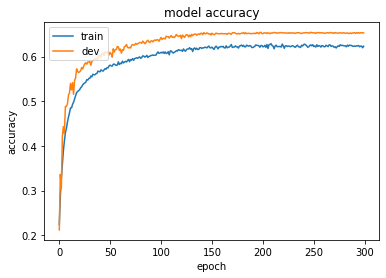

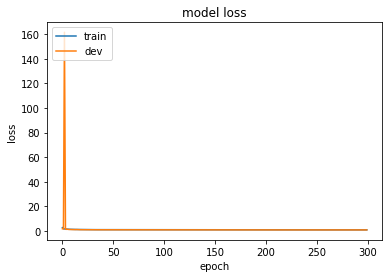

<Figure size 432x288 with 0 Axes>

In [42]:
# list all data in history
print(hist.history.keys())
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
plt.savefig('trained_models/model_accuracy_Basic-EPOCHS_350-DROPOUT_0.3-test_acc_0.646.png')
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
plt.savefig('trained_models/model_loss_Basic-EPOCHS_350-DROPOUT_0.3-test_acc_0.646.png')

In [40]:
np.save('trained_models/hist_baseline.npy',hist.history)
X = np.load('/usr/users/gpupro/gprcsr1_1/Desktop/ST7_FER_Projet/ST7_FER_Github/ST7_models/trained_models/hist_baseline.npy',allow_pickle=True).item()
print(X.keys(),len(X['accuracy']))

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr']) 300


### Save the model in the folder *trained_models*

In [14]:
epoch_str = '-EPOCHS_' + str(Epochs)
dropout_str = '-DROPOUT_' + str(Dropout_rate)
test_acc = '-test_acc_%.3f' % results_test[1]
model_name = 'trained_models/' + 'Basic' + 'lr_0.1-decay_0.001' + epoch_str + dropout_str + test_acc + '.h5'
model.save(model_name)

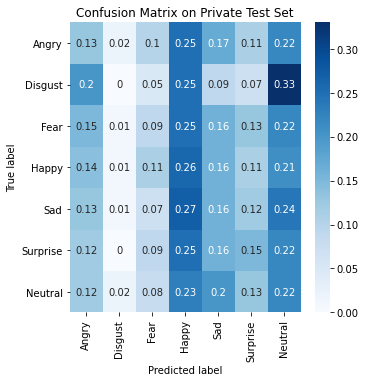

In [15]:
emotions = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

y_pred = model.predict(dev_generator).argmax(axis=1)
y_true = dev_generator.classes

cmat_df_test=pd.DataFrame(
  confusion_matrix(y_true, y_pred, normalize='true').round(2),
  index=emotions.values(), 
  columns=emotions.values()
  )

plt.figure(figsize=(5,5))
heatmap(cmat_df_test,annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.title('Confusion Matrix on Private Test Set')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## TTA method 
We use Test-Time Augmentation(TTA) with horizontal flip and seven augmented images to improve the test accuracy of our five-layer

In [16]:
import utils
from keras.models import load_model
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [17]:
#model = load_model('/usr/users/gpupro/gprcsr1_1/Desktop/ST7_FER_Projet/ST7_FER_Github/ST7_models/trained_models/Basic-EPOCHS_350-DROPOUT_0.3-test_acc_0.646.h5') 
## Function that reads the data from the csv file, increases the size of the images and returns the images and their labels
# print('Getting data. It may take a few minutes')
# test_dataset_dir = '/usr/users/gpupro/gprcsr1_1/Desktop/ST7_FER_Projet/FER_Dataset/csv/test.csv'
# X_test, X_res_test, Y_test = utils.get_data(test_dataset_dir)
# print('Import dataset successfully')

In [18]:
# print('\n# Evaluate on test data')
# TTA_results_test = utils.tta_evaluate_model(model, X_test, Y_test)
# print('test loss, test acc:', results_test)
# print('TTA test acc:', TTA_results_test)